# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Obtain Data

Read csv with election results into pandas, scrub county names to match formatting of census data, filter for 2020 Biden vote proportion and drop unneeded columns

In [2]:
election_csv_df = pd.read_csv('Data/election_results.csv')
election_csv_df = election_csv_df[(election_csv_df['year']==2020) & (election_csv_df['candidate']=='JOSEPH R BIDEN JR')]
election_csv_df['County'] = election_csv_df.apply(lambda x: x['county_name'].title() + ' County, ' + x['state'].title(),
                                            axis=1)
election_csv_df['County'] = election_csv_df['County'].apply(lambda x: x.replace('City County', 'City'))
election_csv_df['County'] = election_csv_df['County'].apply(lambda x: x.replace('County County', 'County'))
election_csv_df['County'] = election_csv_df['County'].apply(lambda x: x.replace('Saint', 'St.'))
election_csv_df['County'] = election_csv_df['County'].apply(lambda x: x.replace('St ', 'St. '))
election_csv_df['County'] = election_csv_df['County'].apply(lambda x: x.replace('District Of Columbia County', 'District Of Columbia'))
election_csv_df = election_csv_df[['County', 'candidatevotes', 'totalvotes', 'mode']]

election_df = pd.DataFrame(election_csv_df.groupby(by='County', axis=0).sum()['candidatevotes'])
election_df.reset_index(inplace=True)
election_df.columns=['County', 'Biden Votes']
election_df['Total Votes'] = election_csv_df.groupby(by='County', axis=0).max()['totalvotes'].values

print('election_df shape:', election_df.shape)
election_df.head()

election_df shape: (3155, 3)


,County,Biden Votes,Total Votes
0,"Abbeville County, South Carolina",4101.0,12433.0
1,"Acadia County, Louisiana",5443.0,28425.0
2,"Accomack County, Virginia",7578.0,16962.0
3,"Ada County, Idaho",120539.0,259389.0
4,"Adair County, Iowa",1198.0,4177.0


Read csv with county areas into pandas, scrub county names to match formatting of census data and drop unneeded columns

In [3]:
area_df = pd.read_csv('Data/area.csv')
area_df = area_df[['Areaname', 'LND010200D']]
area_df.columns = ['County', 'Area']
area_df['County']

state_abbrev_df = pd.read_csv('Data/state_abbrev.csv')
def replace_abbrev(row):
    if len(row.split(',')) == 1:
        return row    
    else:
        state_abbrev = row.split(',')[1][1:]
        state = state_abbrev_df[state_abbrev_df['Code']==state_abbrev]['State'].values[0]
        return row.split(',')[0] + ' County, ' + state
area_df['County'] = area_df['County'].apply(replace_abbrev)
area_df['County'] = area_df['County'].apply(lambda x: x.title())
area_df['County'] = area_df['County'].apply(lambda x: x.replace('District Of Columbia', 'District Of Columbia, District Of Columbia'))
area_df['County'] = area_df['County'].apply(lambda x: x.replace('City County', 'City'))
print('area_df shape:', area_df.shape)
area_df.head()

area_df shape: (3198, 2)


,County,Area
0,United States,3794083.06
1,Alabama,52419.02
2,"Autauga County, Alabama",604.45
3,"Baldwin County, Alabama",2026.93
4,"Barbour County, Alabama",904.52


Update Virginia independent cities in area_df table with city instead of County to match formatting of other tables

In [4]:
area_df['Duplicated'] = area_df['County'].duplicated()
duplicate_counties = area_df[area_df['Duplicated']==1]['County'].values

def virginia_cities(row):
    if row['County'] not in duplicate_counties:
        return row
    elif row['Area'] == max(area_df[area_df['County']==row['County']]['Area'].values):
        return row
    else:
        row['County'] = row['County'].replace('County', 'City')
        return row
area_df = area_df.apply(virginia_cities, axis=1)
area_df.drop('Duplicated', inplace=True, axis=1)
area_df.drop_duplicates(subset='County', inplace=True)
area_df.head()

,County,Area
0,United States,3794083.06
1,Alabama,52419.02
2,"Autauga County, Alabama",604.45
3,"Baldwin County, Alabama",2026.93
4,"Barbour County, Alabama",904.52


Read csv with county level education data into pandas and drop unneeded columns

In [5]:
education_df = pd.read_csv('Data/education.csv', header=1)
education_df = education_df[['Geographic Area Name',
                            'Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over', 
                            "Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher"]]
education_df.columns = ['County', 'Persons 25+', 'Persons 25+ w/ Bachelors Degree']
print('education_df shape: ', education_df.shape)
education_df.head()

education_df shape:  (840, 3)


,County,Persons 25+,Persons 25+ w/ Bachelors Degree
0,"Baldwin County, Alabama",159717,51471
1,"Calhoun County, Alabama",79084,15257
2,"Cullman County, Alabama",58795,9241
3,"DeKalb County, Alabama",47007,5999
4,"Elmore County, Alabama",57553,14310


Read csv with county level economic data into pandas and drop unneeded columns

In [6]:
economic_df = pd.read_csv('Data/economics.csv', header=1)
economic_df = economic_df[['Geographic Area Name',
                          'Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Per capita income (dollars)',
                          'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force',
                          'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed',]]
economic_df.columns = ['County', 'Per Capita Income', 'Persons 16+ in Labor Force', 'Persons 16+ Unemployed',]
print('economic_df shape: ', economic_df.shape)
economic_df.head()

economic_df shape:  (840, 4)


,County,Per Capita Income,Persons 16+ in Labor Force,Persons 16+ Unemployed
0,"Baldwin County, Alabama",32443,101561,5549
1,"Calhoun County, Alabama",24579,51001,3754
2,"Cullman County, Alabama",23968,38222,1783
3,"DeKalb County, Alabama",21939,34492,1606
4,"Elmore County, Alabama",31396,37693,1014


Read csv with ethnicity data into pandas and drop unneeded columns

In [7]:
ethnicity_df = pd.read_csv('Data/ethnicity.csv', header=1)
ethnicity_df = ethnicity_df[['Geographic Area Name',
                             'Estimate!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females)',
                             'Estimate!!SEX AND AGE!!Total population',
                             'Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)',
                             'Estimate!!RACE!!Total population!!One race!!White']]
ethnicity_df.columns = ['County', 'Sex Ratio (M/F)', 'Total Persons', 'Hispanic Persons', 'White Persons']
print('ethnicity_df shape: ', ethnicity_df.shape)
ethnicity_df.head()

ethnicity_df shape:  (840, 5)


,County,Sex Ratio (M/F),Total Persons,Hispanic Persons,White Persons
0,"Baldwin County, Alabama",95.7,223234,10534,190912
1,"Calhoun County, Alabama",91.5,113605,4614,82323
2,"Cullman County, Alabama",94.0,83768,3752,N
3,"DeKalb County, Alabama",99.6,71513,10775,59305
4,"Elmore County, Alabama",97.4,81209,2563,61634


Read csv with disability data into pandas and drop unneeded columns

In [8]:
disability_df = pd.read_csv('Data/disability.csv', header=1)
disability_df = disability_df[['Geographic Area Name',
    'Estimate!!Percent with a disability!!Total civilian noninstitutionalized population']]
disability_df.columns = ['County', 'Disability Proportion']
print('disability_df shape: ', disability_df.shape)
disability_df.head()

disability_df shape:  (840, 2)


,County,Disability Proportion
0,"Baldwin County, Alabama",14.4
1,"Calhoun County, Alabama",20.0
2,"Cullman County, Alabama",17.5
3,"DeKalb County, Alabama",10.8
4,"Elmore County, Alabama",12.9


Read csv with demographic data into pandas and drop unneeded columns

In [9]:
demographics_df = pd.read_csv('Data/demographics.csv', header=1)
demographics_df = demographics_df[['Geographic Area Name',
                                  'Estimate!!Total!!Total population!!SUMMARY INDICATORS!!Median age (years)']]
demographics_df.columns = ['County', 'Median Age']
print('demographics_df shape: ', demographics_df.shape)
demographics_df.head()

demographics_df shape:  (840, 2)


,County,Median Age
0,"Baldwin County, Alabama",43.0
1,"Calhoun County, Alabama",39.6
2,"Cullman County, Alabama",41.9
3,"DeKalb County, Alabama",37.7
4,"Elmore County, Alabama",39.0


Read csv with veteran proprtion into pandas and drop unneeded columns

In [10]:
veterans_df = pd.read_csv('Data/veterans.csv', header=1)
veterans_df = veterans_df[['Geographic Area Name',
                           'Estimate!!Total!!Civilian population 18 years and over',
                           'Estimate!!Veterans!!Civilian population 18 years and over']]
veterans_df.columns = ['County', 'Civilians 18+', 'Veterans 18+']
print('veterans_df shape: ', veterans_df.shape)
veterans_df.head()

veterans_df shape:  (840, 3)


,County,Civilians 18+,Veterans 18+
0,"Baldwin County, Alabama",176331,19580
1,"Calhoun County, Alabama",87525,8552
2,"Cullman County, Alabama",64955,4907
3,"DeKalb County, Alabama",53737,3499
4,"Elmore County, Alabama",61837,6512


Read csv with employment data into pandas and drop unneeded columns

In [11]:
occupation_df = pd.read_csv('Data/occupation.csv', header=1)
occupation_df = occupation_df[['Geographic Area Name',
                           'Estimate!!Total!!Civilian employed population 16 years and over',
                           'Estimate!!Total!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining:!!Agriculture, forestry, fishing and hunting',
                           'Estimate!!Total!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining:!!Mining, quarrying, and oil and gas extraction',
                           'Estimate!!Total!!Civilian employed population 16 years and over!!Manufacturing']]
occupation_df.columns = ['County', 'Employees 16+', 'Agriculture Employees 16+', 'Mining Employees 16+', 
                          'Manufacturing Employees 16+']
print('occupation_df shape: ', occupation_df.shape)
occupation_df.head()

occupation_df shape:  (840, 5)


,County,Employees 16+,Agriculture Employees 16+,Mining Employees 16+,Manufacturing Employees 16+
0,"Baldwin County, Alabama",96012,1090,205,8791
1,"Calhoun County, Alabama",45641,298,714,7044
2,"Cullman County, Alabama",36439,399,0,5282
3,"DeKalb County, Alabama",32544,845,7,9052
4,"Elmore County, Alabama",35358,101,77,4634


Merge all dfs from census sources together

In [12]:
df = pd.merge(education_df, economic_df, on='County')
df = pd.merge(df, ethnicity_df, on='County')
df = pd.merge(df, disability_df, on='County')
df = pd.merge(df, demographics_df, on='County')
df = pd.merge(df, veterans_df, on='County')
df = pd.merge(df, occupation_df, on='County')
print('df shape:', df.shape)
df.head()

df shape: (840, 18)


,County,Persons 25+,Persons 25+ w/ Bachelors Degree,Per Capita Income,Persons 16+ in Labor Force,Persons 16+ Unemployed,Sex Ratio (M/F),Total Persons,Hispanic Persons,White Persons,Disability Proportion,Median Age,Civilians 18+,Veterans 18+,Employees 16+,Agriculture Employees 16+,Mining Employees 16+,Manufacturing Employees 16+
0,"Baldwin County, Alabama",159717,51471,32443,101561,5549,95.7,223234,10534,190912,14.4,43.0,176331,19580,96012,1090,205,8791
1,"Calhoun County, Alabama",79084,15257,24579,51001,3754,91.5,113605,4614,82323,20.0,39.6,87525,8552,45641,298,714,7044
2,"Cullman County, Alabama",58795,9241,23968,38222,1783,94.0,83768,3752,N,17.5,41.9,64955,4907,36439,399,0,5282
3,"DeKalb County, Alabama",47007,5999,21939,34492,1606,99.6,71513,10775,59305,10.8,37.7,53737,3499,32544,845,7,9052
4,"Elmore County, Alabama",57553,14310,31396,37693,1014,97.4,81209,2563,61634,12.9,39.0,61837,6512,35358,101,77,4634


Scrub county names in df with census data to match county names in other dfs for subsequent merger

In [13]:
def scrub_county(name):
    name = name.replace('Parish', 'County')
    name = name.replace('ñ', 'n')
    name = name.replace('Saint', 'St.')
    name = name.replace('City County', 'City')
    name = name.title()
    return name
df['County'] = df['County'].apply(scrub_county)

Merge df with election results

In [14]:
df = pd.merge(df, election_df, on='County')
print('df shape:', df.shape)
df.head()

df shape: (826, 20)


,County,Persons 25+,Persons 25+ w/ Bachelors Degree,Per Capita Income,Persons 16+ in Labor Force,Persons 16+ Unemployed,Sex Ratio (M/F),Total Persons,Hispanic Persons,White Persons,Disability Proportion,Median Age,Civilians 18+,Veterans 18+,Employees 16+,Agriculture Employees 16+,Mining Employees 16+,Manufacturing Employees 16+,Biden Votes,Total Votes
0,"Baldwin County, Alabama",159717,51471,32443,101561,5549,95.7,223234,10534,190912,14.4,43.0,176331,19580,96012,1090,205,8791,24578.0,109679.0
1,"Calhoun County, Alabama",79084,15257,24579,51001,3754,91.5,113605,4614,82323,20.0,39.6,87525,8552,45641,298,714,7044,15216.0,50983.0
2,"Cullman County, Alabama",58795,9241,23968,38222,1783,94.0,83768,3752,N,17.5,41.9,64955,4907,36439,399,0,5282,4478.0,41851.0
3,"Dekalb County, Alabama",47007,5999,21939,34492,1606,99.6,71513,10775,59305,10.8,37.7,53737,3499,32544,845,7,9052,4281.0,29356.0
4,"Elmore County, Alabama",57553,14310,31396,37693,1014,97.4,81209,2563,61634,12.9,39.0,61837,6512,35358,101,77,4634,10367.0,41030.0


Scrub area_df county names to match df county names

In [15]:
missing_counties = pd.merge(area_df, df, on='County', how='right')[pd.merge(area_df, df, on='County', how='right').isna().max(axis=1)]['County'].values
replacement_counties = []
for county in missing_counties:
    replacement_counties.append(county.replace('City', 'County'))
for num in range(0, len(missing_counties)):
    area_df['County'] = area_df['County'].apply(lambda x: x.replace(replacement_counties[num], missing_counties[num]))

Merge df with area_df

In [16]:
df = pd.merge(df, area_df, on='County')
print('df shape:', df.shape)
df.head()

df shape: (826, 21)


,County,Persons 25+,Persons 25+ w/ Bachelors Degree,Per Capita Income,Persons 16+ in Labor Force,Persons 16+ Unemployed,Sex Ratio (M/F),Total Persons,Hispanic Persons,White Persons,...,Median Age,Civilians 18+,Veterans 18+,Employees 16+,Agriculture Employees 16+,Mining Employees 16+,Manufacturing Employees 16+,Biden Votes,Total Votes,Area
0,"Baldwin County, Alabama",159717,51471,32443,101561,5549,95.7,223234,10534,190912,...,43.0,176331,19580,96012,1090,205,8791,24578.0,109679.0,2026.93
1,"Calhoun County, Alabama",79084,15257,24579,51001,3754,91.5,113605,4614,82323,...,39.6,87525,8552,45641,298,714,7044,15216.0,50983.0,612.32
2,"Cullman County, Alabama",58795,9241,23968,38222,1783,94.0,83768,3752,N,...,41.9,64955,4907,36439,399,0,5282,4478.0,41851.0,754.82
3,"Dekalb County, Alabama",47007,5999,21939,34492,1606,99.6,71513,10775,59305,...,37.7,53737,3499,32544,845,7,9052,4281.0,29356.0,778.65
4,"Elmore County, Alabama",57553,14310,31396,37693,1014,97.4,81209,2563,61634,...,39.0,61837,6512,35358,101,77,4634,10367.0,41030.0,657.21


# Scrub Data

Use df.info() to see what data scrubbing needed

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 826 entries, 0 to 825
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   County                           826 non-null    object 
 1   Persons 25+                      826 non-null    int64  
 2   Persons 25+ w/ Bachelors Degree  826 non-null    int64  
 3   Per Capita Income                826 non-null    int64  
 4   Persons 16+ in Labor Force       826 non-null    int64  
 5   Persons 16+ Unemployed           826 non-null    int64  
 6   Sex Ratio (M/F)                  826 non-null    float64
 7   Total Persons                    826 non-null    int64  
 8   Hispanic Persons                 826 non-null    int64  
 9   White Persons                    826 non-null    object 
 10  Disability Proportion            826 non-null    float64
 11  Median Age                       826 non-null    float64
 12  Civilians 18+         

Replace all N datapoints, signifying a missing value, with np.nan and change column data types to int

In [18]:
replace_dict = {'N': np.nan}
df = df.replace(replace_dict)
dtype_dict = {'White Persons': float, 'Employees 16+': float, 'Agriculture Employees 16+': float,
              'Mining Employees 16+': float, 'Manufacturing Employees 16+': float}
df = df.astype(dtype_dict)
df.head()

,County,Persons 25+,Persons 25+ w/ Bachelors Degree,Per Capita Income,Persons 16+ in Labor Force,Persons 16+ Unemployed,Sex Ratio (M/F),Total Persons,Hispanic Persons,White Persons,...,Median Age,Civilians 18+,Veterans 18+,Employees 16+,Agriculture Employees 16+,Mining Employees 16+,Manufacturing Employees 16+,Biden Votes,Total Votes,Area
0,"Baldwin County, Alabama",159717,51471,32443,101561,5549,95.7,223234,10534,190912.0,...,43.0,176331,19580,96012.0,1090.0,205.0,8791.0,24578.0,109679.0,2026.93
1,"Calhoun County, Alabama",79084,15257,24579,51001,3754,91.5,113605,4614,82323.0,...,39.6,87525,8552,45641.0,298.0,714.0,7044.0,15216.0,50983.0,612.32
2,"Cullman County, Alabama",58795,9241,23968,38222,1783,94.0,83768,3752,NaN,...,41.9,64955,4907,36439.0,399.0,0.0,5282.0,4478.0,41851.0,754.82
3,"Dekalb County, Alabama",47007,5999,21939,34492,1606,99.6,71513,10775,59305.0,...,37.7,53737,3499,32544.0,845.0,7.0,9052.0,4281.0,29356.0,778.65
4,"Elmore County, Alabama",57553,14310,31396,37693,1014,97.4,81209,2563,61634.0,...,39.0,61837,6512,35358.0,101.0,77.0,4634.0,10367.0,41030.0,657.21


Fill in missing vote total for San Joaquin County, California with manually researched number

In [19]:
df.loc[df[df['County']=='San Joaquin County, California'].index, 'Total Votes'] = 288492
df[df['County']=='San Joaquin County, California']

,County,Persons 25+,Persons 25+ w/ Bachelors Degree,Per Capita Income,Persons 16+ in Labor Force,Persons 16+ Unemployed,Sex Ratio (M/F),Total Persons,Hispanic Persons,White Persons,...,Median Age,Civilians 18+,Veterans 18+,Employees 16+,Agriculture Employees 16+,Mining Employees 16+,Manufacturing Employees 16+,Biden Votes,Total Votes,Area
67,"San Joaquin County, California",484712,96795,28919,348301,21705,99.9,762148,320334,431364.0,...,34.7,558269,25650,326476.0,16456.0,447.0,26476.0,161137.0,288492.0,1426.25


Fill in miising area for Broomfield County, Colorado with manually researched number

In [20]:
df.loc[df[df['County']=='Broomfield County, Colorado'].index, 'Area'] = 33.03
df[df['County']=='Broomfield County, Colorado']

,County,Persons 25+,Persons 25+ w/ Bachelors Degree,Per Capita Income,Persons 16+ in Labor Force,Persons 16+ Unemployed,Sex Ratio (M/F),Total Persons,Hispanic Persons,White Persons,...,Median Age,Civilians 18+,Veterans 18+,Employees 16+,Agriculture Employees 16+,Mining Employees 16+,Manufacturing Employees 16+,Biden Votes,Total Votes,Area
86,"Broomfield County, Colorado",49543,28176,57213,42235,832,102.0,70465,8964,60615.0,...,38.9,54923,3876,41403.0,146.0,109.0,3734.0,29077.0,46632.0,33.03


Replace all 0 Agriculture Employees 16+ and Mining Employees 16+ values with np.nan to subsequently impute

In [21]:
zero_replace_dict = {0: np.nan}
df['Agriculture Employees 16+'] = df['Agriculture Employees 16+'].replace(zero_replace_dict)
df['Mining Employees 16+'] = df['Mining Employees 16+'].replace(zero_replace_dict)
df.head()

,County,Persons 25+,Persons 25+ w/ Bachelors Degree,Per Capita Income,Persons 16+ in Labor Force,Persons 16+ Unemployed,Sex Ratio (M/F),Total Persons,Hispanic Persons,White Persons,...,Median Age,Civilians 18+,Veterans 18+,Employees 16+,Agriculture Employees 16+,Mining Employees 16+,Manufacturing Employees 16+,Biden Votes,Total Votes,Area
0,"Baldwin County, Alabama",159717,51471,32443,101561,5549,95.7,223234,10534,190912.0,...,43.0,176331,19580,96012.0,1090.0,205.0,8791.0,24578.0,109679.0,2026.93
1,"Calhoun County, Alabama",79084,15257,24579,51001,3754,91.5,113605,4614,82323.0,...,39.6,87525,8552,45641.0,298.0,714.0,7044.0,15216.0,50983.0,612.32
2,"Cullman County, Alabama",58795,9241,23968,38222,1783,94.0,83768,3752,NaN,...,41.9,64955,4907,36439.0,399.0,NaN,5282.0,4478.0,41851.0,754.82
3,"Dekalb County, Alabama",47007,5999,21939,34492,1606,99.6,71513,10775,59305.0,...,37.7,53737,3499,32544.0,845.0,7.0,9052.0,4281.0,29356.0,778.65
4,"Elmore County, Alabama",57553,14310,31396,37693,1014,97.4,81209,2563,61634.0,...,39.0,61837,6512,35358.0,101.0,77.0,4634.0,10367.0,41030.0,657.21


Calculate interaction independent variables and drop variables used to calculate interacitons

In [22]:
df['Bachelors Degree Proportion'] = df['Persons 25+ w/ Bachelors Degree']/df['Persons 25+']
df.drop(columns=['Persons 25+ w/ Bachelors Degree', 'Persons 25+'], inplace=True)

df['Unemployment Rate'] = df['Persons 16+ Unemployed']/df['Persons 16+ in Labor Force']
df.drop(columns=['Persons 16+ Unemployed', 'Persons 16+ in Labor Force'], inplace=True)

df['Hispanic Population Proportion'] = df['Hispanic Persons']/df['Total Persons']
df.drop(columns=['Hispanic Persons'], inplace=True)

df['White Population Proportion'] = df['White Persons']/df['Total Persons']
df.drop(columns=['White Persons'], inplace=True)

df['Veteran Population Proportion'] = df['Veterans 18+']/df['Civilians 18+']
df.drop(columns=['Veterans 18+', 'Civilians 18+'], inplace=True)

df['Agriculture Employment Proportion'] = df['Agriculture Employees 16+']/df['Employees 16+']
df.drop(columns=['Agriculture Employees 16+'], inplace=True)

df['Mining Employment Proportion'] = df['Mining Employees 16+']/df['Employees 16+']
df.drop(columns=['Mining Employees 16+'], inplace=True)

df['Manufacturing Employment Proportion'] = df['Manufacturing Employees 16+']/df['Employees 16+']
df.drop(columns=['Manufacturing Employees 16+', 'Employees 16+'], inplace=True)

df['Biden Vote Proportion'] = df['Biden Votes']/df['Total Votes']
df.drop(columns=['Biden Votes', 'Total Votes'], inplace=True)

df['Population Density'] = df['Total Persons']/df['Area']
df.drop(columns=['Total Persons', 'Area'], inplace=True)

df.head()

,County,Per Capita Income,Sex Ratio (M/F),Disability Proportion,Median Age,Bachelors Degree Proportion,Unemployment Rate,Hispanic Population Proportion,White Population Proportion,Veteran Population Proportion,Agriculture Employment Proportion,Mining Employment Proportion,Manufacturing Employment Proportion,Biden Vote Proportion,Population Density
0,"Baldwin County, Alabama",32443,95.7,14.4,43.0,0.322264,0.054637,0.047188,0.855210,0.111041,0.011353,0.002135,0.091561,0.224090,110.134045
1,"Calhoun County, Alabama",24579,91.5,20.0,39.6,0.192921,0.073606,0.040614,0.724642,0.097709,0.006529,0.015644,0.154335,0.298452,185.532075
2,"Cullman County, Alabama",23968,94.0,17.5,41.9,0.157173,0.046649,0.044790,NaN,0.075545,0.010950,NaN,0.144955,0.106999,110.977452
3,"Dekalb County, Alabama",21939,99.6,10.8,37.7,0.127619,0.046562,0.150672,0.829290,0.065113,0.025965,0.000215,0.278147,0.145830,91.842291
4,"Elmore County, Alabama",31396,97.4,12.9,39.0,0.248640,0.026902,0.031561,0.758955,0.105309,0.002856,0.002178,0.131059,0.252669,123.566288


Drop columns not useful for modeling

In [23]:
df.drop(columns=['County'], inplace=True)

Impute missing values

In [24]:
impute_x = df.drop(columns=['Biden Vote Proportion'])
impute_y = df['Biden Vote Proportion']
impute_x_train, impute_x_test, impute_y_train, impute_y_test = train_test_split(impute_x, impute_y, random_state=31, test_size=.2)
imputed_train_index = impute_x_train.index
imputed_test_index = impute_x_test.index

train_imputer_ss = StandardScaler()
ss_impute_x_train = pd.DataFrame(train_imputer_ss.fit_transform(impute_x_train), columns=impute_x_train.columns)
train_imputer = KNNImputer()
imputed_x_train = pd.DataFrame(train_imputer.fit_transform(ss_impute_x_train), columns=ss_impute_x_train.columns)
imputed_x_train = pd.DataFrame(train_imputer_ss.inverse_transform(imputed_x_train), columns = imputed_x_train.columns)
imputed_x_train['Index'] = imputed_train_index

test_imputer_ss = StandardScaler()
ss_impute_x_test = pd.DataFrame(test_imputer_ss.fit_transform(impute_x_test), columns=impute_x_test.columns)
test_imputer = KNNImputer()
imputed_x_test = pd.DataFrame(test_imputer.fit_transform(ss_impute_x_test), columns=ss_impute_x_test.columns)
imputed_x_test = pd.DataFrame(test_imputer_ss.inverse_transform(imputed_x_test), columns = imputed_x_test.columns)
imputed_x_test['Index'] = imputed_test_index

df = pd.concat([imputed_x_train, imputed_x_test])
df.sort_values(by='Index', inplace=True)
df.set_index('Index', drop=True, inplace=True)
df['Biden Vote Proportion'] = impute_y
df.head()

,Per Capita Income,Sex Ratio (M/F),Disability Proportion,Median Age,Bachelors Degree Proportion,Unemployment Rate,Hispanic Population Proportion,White Population Proportion,Veteran Population Proportion,Agriculture Employment Proportion,Mining Employment Proportion,Manufacturing Employment Proportion,Population Density,Biden Vote Proportion
Index,,,,,,,,,,,,,,
0,32443.0,95.7,14.4,43.0,0.322264,0.054637,0.047188,0.855210,0.111041,0.011353,0.002135,0.091561,110.134045,0.224090
1,24579.0,91.5,20.0,39.6,0.192921,0.073606,0.040614,0.724642,0.097709,0.006529,0.015644,0.154335,185.532075,0.298452
2,23968.0,94.0,17.5,41.9,0.157173,0.046649,0.044790,0.853513,0.075545,0.010950,0.006584,0.144955,110.977452,0.106999
3,21939.0,99.6,10.8,37.7,0.127619,0.046562,0.150672,0.829290,0.065113,0.025965,0.000215,0.278147,91.842291,0.145830
4,31396.0,97.4,12.9,39.0,0.248640,0.026902,0.031561,0.758955,0.105309,0.002856,0.002178,0.131059,123.566288,0.252669


Confirm data is scrubbed with df.info()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 826 entries, 0 to 825
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Per Capita Income                    826 non-null    float64
 1   Sex Ratio (M/F)                      826 non-null    float64
 2   Disability Proportion                826 non-null    float64
 3   Median Age                           826 non-null    float64
 4   Bachelors Degree Proportion          826 non-null    float64
 5   Unemployment Rate                    826 non-null    float64
 6   Hispanic Population Proportion       826 non-null    float64
 7   White Population Proportion          826 non-null    float64
 8   Veteran Population Proportion        826 non-null    float64
 9   Agriculture Employment Proportion    826 non-null    float64
 10  Mining Employment Proportion         826 non-null    float64
 11  Manufacturing Employment Proport

# Explore Data

Find the 10 greatest outlier variables with isolation forest

In [26]:
isolation_df = df.drop(columns=['Biden Vote Proportion'])
isf_ss = StandardScaler()
isolation_df = pd.DataFrame(isf_ss.fit_transform(isolation_df), columns=isolation_df.columns)
isolation_forest = IsolationForest(contamination=.011)
isolation_df['Outlier'] = isolation_forest.fit_predict(isolation_df)
isolation_df[isolation_df['Outlier']==-1]

,Per Capita Income,Sex Ratio (M/F),Disability Proportion,Median Age,Bachelors Degree Proportion,Unemployment Rate,Hispanic Population Proportion,White Population Proportion,Veteran Population Proportion,Agriculture Employment Proportion,Mining Employment Proportion,Manufacturing Employment Proportion,Population Density,Outlier
30,-1.418760,1.871032,-0.179121,-0.890029,-1.515656,5.794996,3.817617,0.713688,0.181350,4.780407,-0.387324,-0.772180,-0.274097,-1
48,-1.771729,1.649407,0.227506,-1.487706,-1.128641,4.018925,5.308585,-0.581914,-1.251047,3.826157,0.061320,-1.510213,-0.273377,-1
50,-1.274407,4.973785,-0.237211,-1.594434,-1.201262,1.146112,3.134802,-0.183601,-0.217626,7.436387,-0.246341,-0.959430,-0.243916,-1
56,-1.069123,1.024827,-0.121032,-1.615780,-1.491380,3.143952,3.555454,-1.850039,-1.163208,6.075387,-0.357187,-0.015502,-0.230808,-1
106,3.108429,-1.433197,-0.672882,-1.060794,2.643229,1.057684,-0.077817,-2.413252,-1.294155,-0.522383,-0.386404,-1.706376,4.088634,-1
438,-0.794936,2.092658,-0.643837,-1.338287,-1.618414,-0.159055,3.487406,0.698091,-1.356803,-0.057298,13.986004,-1.557169,-0.283664,-1
446,-1.313917,-1.554084,0.546998,-0.954066,-0.947497,2.757841,3.216585,-3.762881,-1.959512,-0.563759,-0.386404,-1.332837,10.181149,-1
461,5.835071,-1.433197,-0.847151,-0.356389,2.853570,-0.132256,0.968292,-1.450965,-2.151912,-0.573629,-0.414178,-1.373596,20.161056,-1
745,4.861253,0.218918,-2.125120,-0.911375,4.033688,-1.359613,0.239090,-0.394771,-0.528885,-0.544367,-0.363620,-1.537122,3.578214,-1
763,4.135561,-0.768322,-2.037986,-0.463117,3.211447,-0.981730,0.312633,-0.991503,0.220606,-0.546359,-0.392394,-1.499885,4.096573,-1


Calculate descriptive statistics for each variable

In [27]:
df.describe()

,Per Capita Income,Sex Ratio (M/F),Disability Proportion,Median Age,Bachelors Degree Proportion,Unemployment Rate,Hispanic Population Proportion,White Population Proportion,Veteran Population Proportion,Agriculture Employment Proportion,Mining Employment Proportion,Manufacturing Employment Proportion,Population Density,Biden Vote Proportion
count,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000
mean,33687.851090,97.113438,13.616707,39.269613,0.307534,0.044552,0.123271,0.779742,0.079587,0.013317,0.006303,0.110010,685.118134,0.451885
std,8408.098692,4.966343,3.445047,4.687643,0.109472,0.016737,0.137037,0.147019,0.028496,0.021607,0.015096,0.057899,2359.651344,0.149841
min,15589.000000,84.200000,5.800000,25.100000,0.110110,0.009905,0.003816,0.117057,0.016730,0.000018,0.000023,0.010764,6.407943,0.106999
25%,28126.000000,94.125000,11.200000,36.600000,0.224982,0.033157,0.043011,0.716623,0.063076,0.003647,0.000754,0.068397,131.004177,0.335951
50%,32221.000000,96.700000,13.300000,39.000000,0.293635,0.042425,0.072993,0.816722,0.075534,0.007107,0.002073,0.100442,242.342727,0.433991
75%,37359.500000,99.200000,15.700000,41.675000,0.369708,0.052915,0.143834,0.885818,0.090464,0.014080,0.005940,0.143238,517.696332,0.555152
max,82720.000000,144.300000,27.600000,68.900000,0.748842,0.141486,0.953902,0.964707,0.213289,0.250000,0.217307,0.420073,48229.375185,0.921497


Plot distribution of each variable in dataset

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

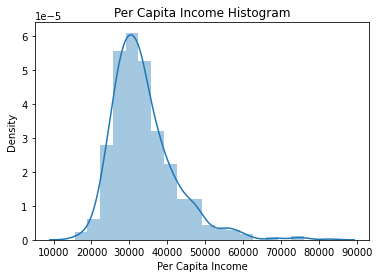

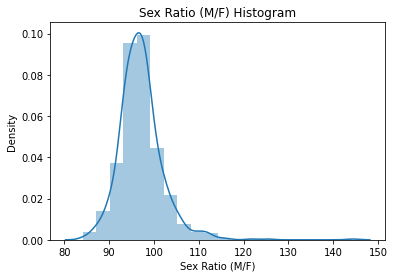

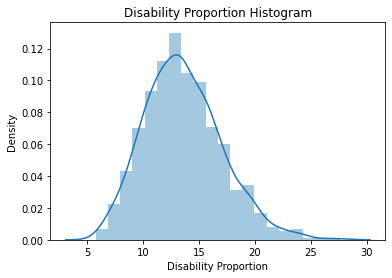

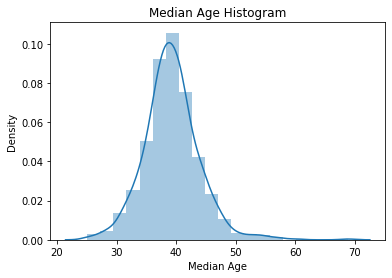

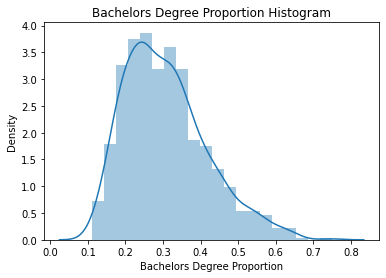

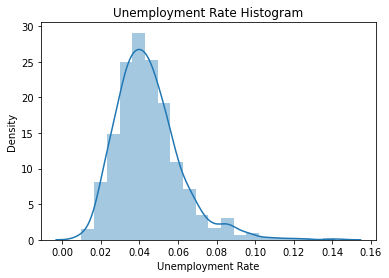

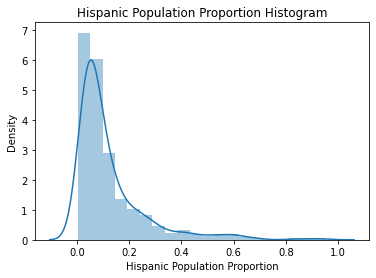

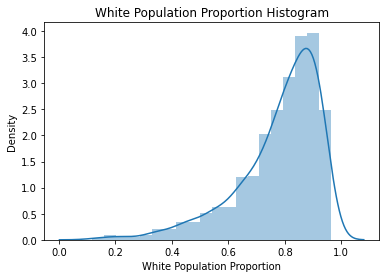

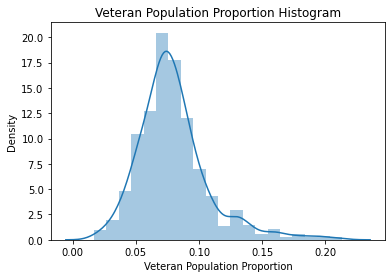

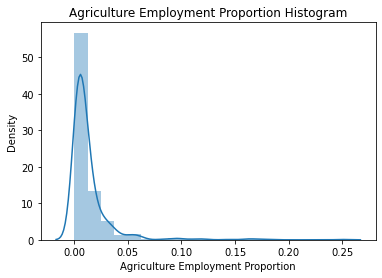

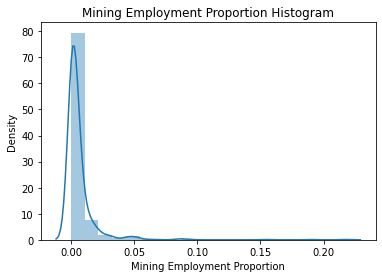

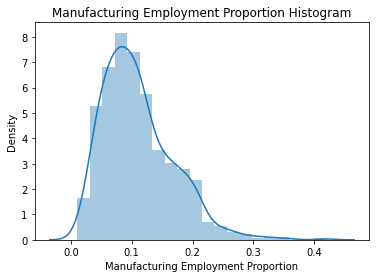

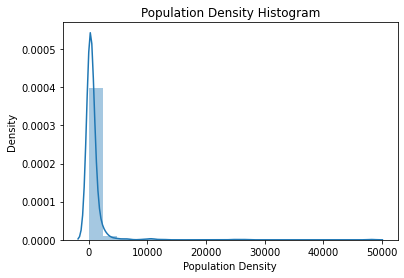

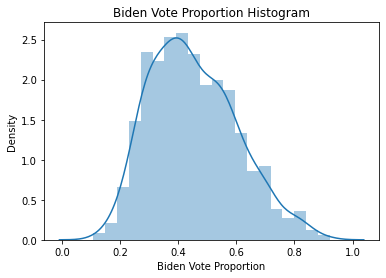

In [28]:
for col in df.columns:
    fig, ax = plt.subplots()
    sns.distplot(df[col], bins=20, ax=ax)
    ax.set_title(f'{col} Histogram')

Plot relationship between each independent variable and the dependent variable

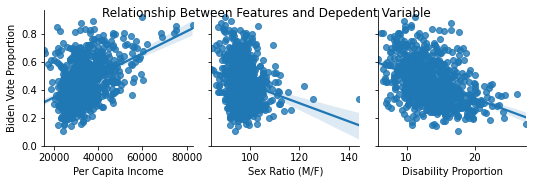

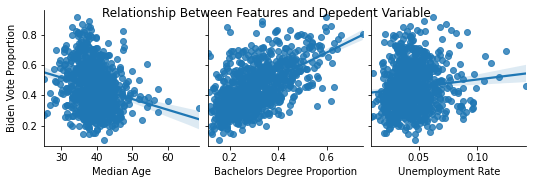

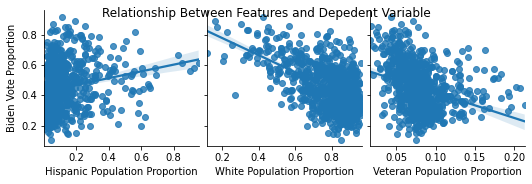

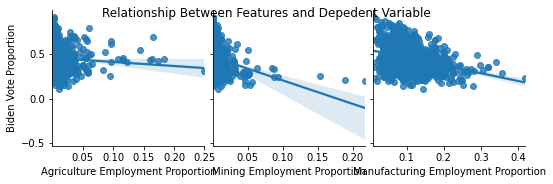

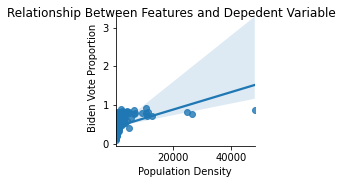

In [29]:
y_var = 'Biden Vote Proportion'
x_vars = list(df.columns)
x_vars.remove(y_var)

x_vars_lists = []
for num in range(0, len(x_vars), 3):
    x_vars_lists.append(x_vars[num: num+3])
x_vars_lists

for x_vars_list in x_vars_lists:
    pairplot = sns.pairplot(df, x_vars=x_vars_list, y_vars=y_var, kind='reg')
    pairplot.fig.suptitle('Relationship Between Features and Depedent Variable')

Calculate correlations between features

In [30]:
correlation_df = df.corr()
correlation_df[(correlation_df>.6) | (correlation_df<-.6)]

,Per Capita Income,Sex Ratio (M/F),Disability Proportion,Median Age,Bachelors Degree Proportion,Unemployment Rate,Hispanic Population Proportion,White Population Proportion,Veteran Population Proportion,Agriculture Employment Proportion,Mining Employment Proportion,Manufacturing Employment Proportion,Population Density,Biden Vote Proportion
Per Capita Income,1.000000,NaN,NaN,NaN,0.819784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex Ratio (M/F),NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Disability Proportion,NaN,NaN,1.000000,NaN,-0.635761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Median Age,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bachelors Degree Proportion,0.819784,NaN,-0.635761,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unemployment Rate,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hispanic Population Proportion,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
White Population Proportion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Veteran Population Proportion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Agriculture Employment Proportion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


# Model Data

Create x and y variables

In [31]:
y = df['Biden Vote Proportion']
x = df.drop(columns='Biden Vote Proportion')

Perform Train Test Split

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=31, test_size=.2)

Apply standard scaler to x and y variables

In [33]:
ss = StandardScaler()
ss.fit(x_train)
x_train = pd.DataFrame(ss.transform(x_train), columns = x.columns)
x_test = pd.DataFrame(ss.transform(x_test), columns = x.columns)
x_train.head()

,Per Capita Income,Sex Ratio (M/F),Disability Proportion,Median Age,Bachelors Degree Proportion,Unemployment Rate,Hispanic Population Proportion,White Population Proportion,Veteran Population Proportion,Agriculture Employment Proportion,Mining Employment Proportion,Manufacturing Employment Proportion,Population Density
0,0.853427,0.634987,-0.116952,0.556897,0.234494,0.027892,-0.083353,0.184126,1.064640,-0.423452,-0.362300,0.306745,-0.176618
1,-0.112310,-1.534100,0.344906,-0.191851,0.355167,0.188204,-0.591031,-1.782677,-0.151856,-0.575337,-0.298460,-0.077343,-0.018845
2,0.555629,-0.738105,0.402639,-0.108657,0.266435,0.864603,0.385156,-1.008031,-0.834883,-0.544155,-0.420382,-0.670735,1.048495
3,-0.713082,-0.001809,-0.694274,-0.191851,-1.044885,-0.860224,-0.319003,-0.593011,0.419075,0.441778,-0.058920,-0.728985,-0.334582
4,1.645469,-0.240608,-0.954069,0.660890,1.011747,-0.908582,0.155502,0.336588,0.117361,-0.541105,-0.422870,-0.946087,-0.227804


Build and validate dummy regressor model

In [34]:
dr = DummyRegressor()
dr.fit(x_train, y_train)
y_train_pred_dr = dr.predict(x_train)
y_test_pred_dr = dr.predict(x_test)
print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_train_pred_dr)))
print('Train MAE: ', mean_absolute_error(y_train, y_train_pred_dr))
print('Train R Squared: ', r2_score(y_train, y_train_pred_dr))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_test_pred_dr)))
print('Test MAE: ', mean_absolute_error(y_test, y_test_pred_dr))
print('Test R Squared: ', r2_score(y_test, y_test_pred_dr))


Train RMSE:  0.14827091184684607
Train MAE:  0.12121677700034511
Train R Squared:  0.0
Test RMSE:  0.15550643734614036
Test MAE:  0.1280535601439012
Test R Squared:  -0.0007929565956856788


Build and validate linear regression model

In [35]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_lr)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_lr))
print('Train R Squared: ', r2_score(y_train, y_train_pred_lr))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_lr)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_lr))
print('Test R Squared: ', r2_score(y_test, y_test_pred_lr))

Train RMSE 0.086203315027014
Train MAE 0.06890166569961637
Train R Squared:  0.6619849653237166
Test RMSE 0.08939547956511903
Test MAE 0.07158933246691027
Test R Squared:  0.6692661749695517


Gridsearch ridge model

In [36]:
ridge_dict = {'alpha': [x * 0.1 for x in range(0, 110)]}
ridge_model = Ridge()
ridge_gs = GridSearchCV(ridge_model, ridge_dict, cv=5, n_jobs=-1, 
                     scoring='neg_root_mean_squared_error', verbose=1) 
ridge_gs.fit(x_train, y_train)
print('Elastic Net Gridsearch')
print('Best Params', ridge_gs.best_params_)
print('Best Score', ridge_gs.best_score_)

Fitting 5 folds for each of 110 candidates, totalling 550 fits
Elastic Net Gridsearch
Best Params {'alpha': 4.800000000000001}
Best Score -0.08800094876730112


Build and validate ridge model

In [37]:
ridge = Ridge(alpha=4.8)
ridge.fit(x_train, y_train)
y_train_pred_ridge = ridge.predict(x_train)
y_test_pred_ridge = ridge.predict(x_test)
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_ridge)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_ridge))
print('Train R Squared: ', r2_score(y_train, y_train_pred_ridge))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_ridge)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_ridge))
print('Test R Squared: ', r2_score(y_test, y_test_pred_ridge))

Train RMSE 0.08622053179393803
Train MAE 0.06885173383921664
Train R Squared:  0.6618499332263312
Test RMSE 0.08963259961211097
Test MAE 0.0719087090010457
Test R Squared:  0.6675093159158337


Gridsearch Lasso model

In [38]:
lasso_dict = {'alpha': [x * 0.001 for x in range(0, 101)]}
lasso_model = Lasso()
lasso_gs = GridSearchCV(lasso_model, lasso_dict, cv=5, n_jobs=-1, 
                     scoring='neg_root_mean_squared_error', verbose=1) 
lasso_gs.fit(x_train, y_train)
print('Elastic Net Gridsearch')
print('Best Params', lasso_gs.best_params_)
print('Best Score', lasso_gs.best_score_)

Fitting 5 folds for each of 101 candidates, totalling 505 fits
Elastic Net Gridsearch
Best Params {'alpha': 0.002}
Best Score -0.08767835384694492


In [39]:
lasso = Lasso(alpha=.002)
lasso.fit(x_train, y_train)
y_train_pred_lasso = lasso.predict(x_train)
y_test_pred_lasso = lasso.predict(x_test)
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_lasso)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_lasso))
print('Train R Squared: ', r2_score(y_train, y_train_pred_lasso))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_lasso)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_lasso))
print('Test R Squared: ', r2_score(y_test, y_test_pred_lasso))

Train RMSE 0.08654572781299727
Train MAE 0.06898170304587709
Train R Squared:  0.6592943370216497
Test RMSE 0.0896835012035985
Test MAE 0.07236791576297301
Test R Squared:  0.6671315714203623


# Analyze Results

Create df with coefficients from Biden Vote Proportion linear regression model

In [40]:
lr_coefficients_df = pd.DataFrame(lr.coef_, columns=['Coefficient'])
lr_coefficients_df['Feature'] = x_train.columns
lr_coefficients_df.sort_values(by='Coefficient', inplace=True)
lr_coefficients_df.reset_index(drop=True, inplace=True)
lr_coefficients_df

,Coefficient,Feature
0,-0.060800,White Population Proportion
1,-0.025431,Mining Employment Proportion
2,-0.019685,Veteran Population Proportion
3,-0.011020,Per Capita Income
4,-0.006330,Manufacturing Employment Proportion
5,-0.000127,Disability Proportion
6,0.000367,Agriculture Employment Proportion
7,0.001530,Sex Ratio (M/F)
8,0.009126,Population Density
9,0.011184,Median Age


Plot Biden Vote Proportion linear regression model coefficients

Text(0.5, 1.0, '2020 Joe Biden Vote Proportion Linear Regression Coefficients')

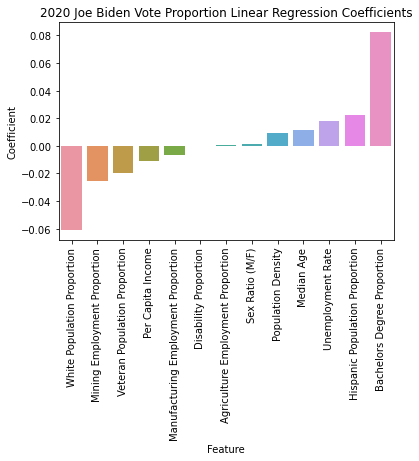

In [41]:
fig, ax = plt.subplots()
sns.barplot(x='Feature', y='Coefficient', data=lr_coefficients_df, ax=ax)
ax.set_xticklabels(lr_coefficients_df['Feature'], rotation=90)
ax.set_title('2020 Joe Biden Vote Proportion Linear Regression Coefficients')